<a href="https://colab.research.google.com/github/isismeira/classificador_algarismos_manuscritos/blob/main/classificacao_algarismos_manuscritos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de algarismos escritos à mão com SGDClassifier, SupportVectorClassifier, K-nearest-neighbors e RandomForests

***Objetivo***: Utilizando um conjunto de dados contendo várias imagens de algarismos manuscritos, desenvolver um modelo preciso capaz de reconhecer e classificar corretamente algarismos escritos à mão

***Métricas utilizadas***: Validação Cruzada, Precisão/Revocação, F1 Score e ROC AUC

***Dataset***: O conjunto de dados MNIST (Modified National Institute of Standards and Technology) é um conjunto de dados composto por cerca de 70 mil imagens de de 28x28 píxels de dígitos escritos à mão por estudantes do ensino médio e funcionários do US Census Bureau

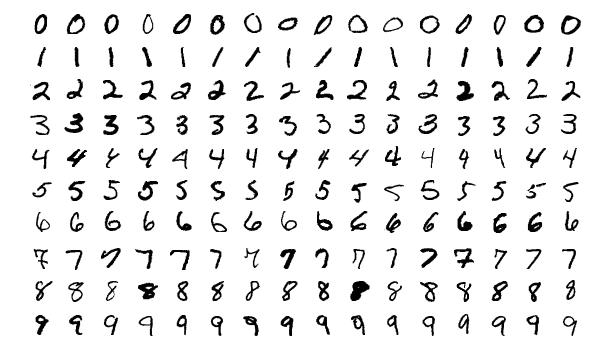

## Algumas importações

In [2]:
import sys
import numpy as np
import os
np.random.seed(42)

## Conhecendo o dataset

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Um conjunto de dados carregados pelo scikit-learn geralmente tem uma estrutura similar a um dicionário.
A chave `DESCR` descreve o conjunto de dados.
A chave `data` contém um array com uma linha por instância e uma coluna por característica.
A chave `target` contém um array com os rótulos.

In [4]:
X, Y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

Existem 70000 imagem com 784 características. Isso porque cada imagem tem 28x28 pixels (= 784) cada característica representa a intensidade de um pixel de 0(branco) a 255(preto)

In [6]:
Y.shape

(70000,)

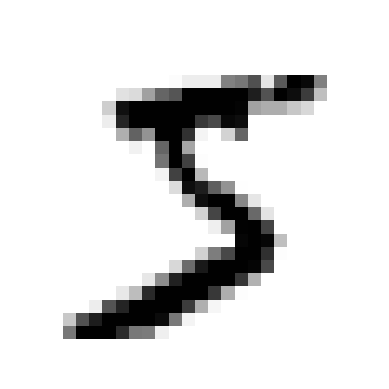

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

algum_digito = X.iloc[0].values
imagem_algum_digito = algum_digito.reshape(28, 28)

plt.imshow(imagem_algum_digito, cmap="binary")
plt.axis("off")
plt.show()

Isso parece um 5, e de fato, seu rótulo corresponde ao dígito 5:

In [8]:
Y[0]

'5'

In [ ]:
Y = Y.astype(np.uint8)

### Separando entre treino e teste...

O conjunto MNIST já está dividido em um conjunto de treinamento (primeiras 60mil imagens) e conjunto de testes (últimas 10 mil). Assegurando que todos os folds de validação cruzada serão semelhantes

In [ ]:
X_treino, X_teste, Y_treino, Y_teste = X[:60000], X[60000:], Y[:60000], Y[60000:]

## Classificação Binária (apenas um algarismo)

Em primeiro lugar, vou tentar criar um classificador simples, identificando somente o que é ou não é o algarismo 5.

In [ ]:
Y_treino_5 = (Y_treino == 5) # True para todos cincos, False para todos outros algarismos
Y_teste_5 = (Y_teste == 5)

O classificador escolhido é o classificados Gradiente Descendente Estocástico (SGD), pois ele lida eficientemente com datasets muito grandes.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_treino, Y_treino_5)

obs. SGDClassifier depende da aleatoriedade, por isso definir um random_state

In [ ]:
sgd.predict([algum_digito])

array([ True])

O classificador classificou corretamente um valor que realmente valia 5

### Desempenho do classificador binário com validação cruzada

Para avaliar o classificador SGD, vou usar o método k-fold de validação cruzada em três partes. O que significa que o método vai dividir o conjunto em três subconjuntos e depois prever e avaliar as predições em cada conjunto

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_treino, Y_treino_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Acurácia acima de 95%

Mas como será a acurácia nas imagens que não são um 5?

In [ ]:
from sklearn.base import BaseEstimator

class Classificador_Nao_5(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
nao_5 = Classificador_Nao_5()
cross_val_score(nao_5, X_treino, Y_treino_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Mais de 90% de acurácia

Isso ocorre pois apenas 10% das imagens são "5". Por isso que acurácia geralmente não é uma medida de desempenho preferida para classificadores, principalmente quando se lida com datasets assimétricos.

### Desempenho do classificador binário com matriz de confusão

Uma forma melhor de avaliar o desempenho desse classificador é através de matrizes de confusão

In [ ]:
from sklearn.model_selection import cross_val_predict

Y_treino_pred = cross_val_predict(sgd, X_treino, Y_treino_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

matriz_confusao = confusion_matrix(Y_treino_5, Y_treino_pred)
matriz_confusao

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Cada linha em uma matriz de confusão representa uma classe real e cada coluna representa uma classe prevista. A estrutura dessa matriz é algo como:

(verdadeiros negativos (TN))   (falsos positivos (FP))

(falsos negativos(FN)) (verdadeiros positivos(TP))

### Desempenho do classificador binário com precisão e revocação

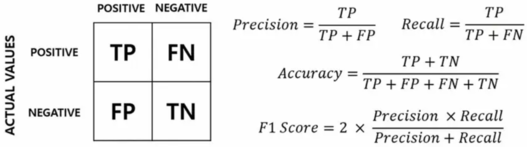

A matriz de confusão é interessante. Mas talvez seja melhor obter uma métrica mais concisa. Algo a ser observado é a *acurácia das predições positivas*, chamada ***precisão***. Além disso, a precisão é acompanhada de outra  métrica chamada ***revocação***, que corresponde à *taxa de verdadeiros positivos*

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(Y_treino_5, Y_treino_pred)

0.8370879772350012

In [ ]:
recall_score(Y_treino_5, Y_treino_pred)

0.6511713705958311

Agora, o detector de 5s não parece tão bom. Já que quando ele afirma que uma imagem é um cinco, ele está correto 83% das vezes, e só detecta 65% dos 5s

Geralmente, é comum combinar a precisão e revocação em uma única métrica chamada F1, que corresponde à média harmônica da precisão e da revocação

In [ ]:
from sklearn.metrics import f1_score
f1_score(Y_treino_5, Y_treino_pred)

0.7325171197343847

A F1 score favorece classificadors que tem precisão e revocação semelhantes, o que não é esse caso...

Em certo contextos, é preciso dar mais ênfase à revocação ou à precisão (por ex. em um classificador de vídeos seguros para crianças, é mais importante ter uma alta precisão, enquanto um detector de ladrões em uma loja é importante ter mais revocação)

Para fazer esse balancemento entre precisão e revocação, utiliza-se o Trade-off precisão-revocação

### Trade-off precisão/revocação

O classificador SGD toma decisões da seguinte forma: ele calcula um score para uma determinada instância e se ela for maior que um limiar ele atribui a instância à uma classe positiva e caso contrário. Para uma classe negativa.

Nesse trade-off de precisão e revocação. quanto maior o limiar, maior a precisão e menor a revocação

In [ ]:
Y_scores = sgd.decision_function([algum_digito])
Y_scores

array([2164.22030239])

In [ ]:
limiar = 0
Y_algum_digito_pred = (Y_scores > limiar)
Y_algum_digito_pred

array([ True])

In [ ]:
limiar = 8000
Y_algum_digito_pred = (Y_scores > limiar)
Y_algum_digito_pred

array([False])

Para decidir qual limiar usar, primeiro usar `cross_val_predict` para obter os scores de decisão de todas as instâncias  no conjunto de treinamento

In [ ]:
Y_scores = cross_val_predict(sgd, X_treino, Y_treino_5, cv=3, method="decision_function")

Agora, só chamar `precision_recall_curve` para todos calcular a precisão e revocação de todos limiares possíveis

In [ ]:
from sklearn.metrics import precision_recall_curve

precisao, revocacao, limiar = precision_recall_curve(Y_treino_5, Y_scores)

In [ ]:
def plot_precisao_revocacao_vs_limiar(precisao, revocacao, limiar):
    plt.plot(limiar, precisao[:-1], "b--", label="Precisão", linewidth=2)
    plt.plot(limiar, revocacao[:-1], "g-", label="Revocação", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


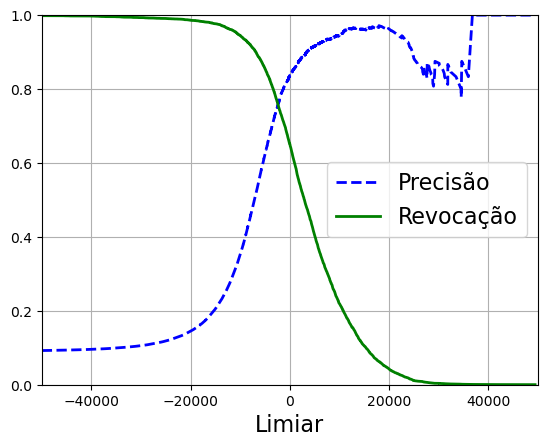

In [ ]:
plot_precisao_revocacao_vs_limiar(precisao, revocacao, limiar)
plt.show()

In [ ]:
def plot_precisao_vs_revocacao(precisao, revocacao):
    plt.plot(revocacao, precisao, "b-", linewidth=2)
    plt.xlabel("Revocação", fontsize=16)
    plt.ylabel("Precisão", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

Pata ficar mais claro, é interessante plotar a precisão diretamente em função da revocação

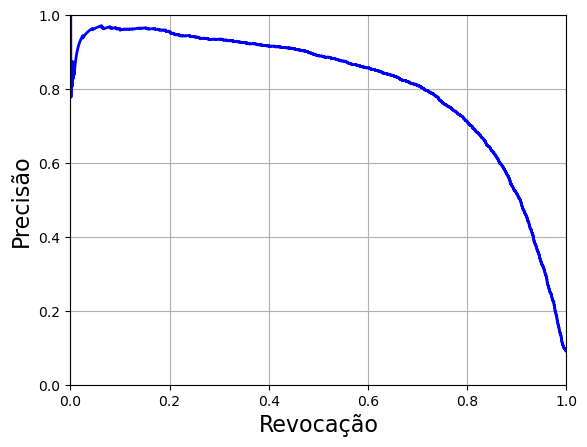

In [ ]:
plot_precisao_vs_revocacao(precisao, revocacao)
plt.show()

A precisão diminui acentuadamente em torno de 80%

Vou escolher 90% de precisão e buscar o mais baixo que fornece pelo menos 90% de precisão

In [ ]:
limiar_90_precisao = limiar[np.argmax(precisao >= 0.90)]

In [ ]:
Y_treino_pred_90 = (Y_scores >= limiar_90_precisao)

In [ ]:
precision_score(Y_treino_5, Y_treino_pred_90)

0.9000345901072293

In [ ]:
recall_score(Y_treino_5, Y_treino_pred_90)

0.4799852425751706

Agora tenho um classificador de precisão 90%. No entanto, um classificador de alta precisão não é muito útil se sua revocação for baixa

### A curva ROC

A curva característica de revocação (ROC) representa a taxa de verdadeiros positivos em relação a taxa de positivos falsos

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, limiar = roc_curve(Y_treino_5, Y_scores)

In [ ]:
def plot_curva_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falsos positivos ', fontsize=16)
    plt.ylabel('Taxa de verdadeiros positivos', fontsize=16)
    plt.grid(True)

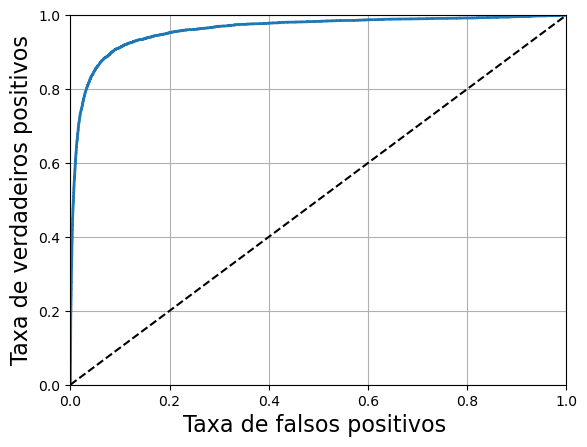

In [ ]:
plot_curva_roc(fpr, tpr)
plt.show()

Um bom classificador fica bem distante da linha pontilhada, que corresponde à curva ROC do classificador

Uma forma de classificar os classificadores é comparando a área sobre curva (AUC)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_treino_5, Y_scores)

0.9604938554008616

### Comparando curva ROC de Florestas Aleatórias com SGC

Agora, vou treinar um RandomForestClassfier e comparar sua ROC AUC com a do SGDClassfier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

floresta = RandomForestClassifier(random_state=42)

In [ ]:
Y_proba_floresta = cross_val_predict(floresta, X_treino, Y_treino_5, cv=3, method="predict_proba")

In [ ]:
Y_scores_floresta  = Y_proba_floresta[:, 1]
fpr_floresta, tpr_floresta, limiar_floresta = roc_curve(Y_treino_5, Y_scores_floresta)

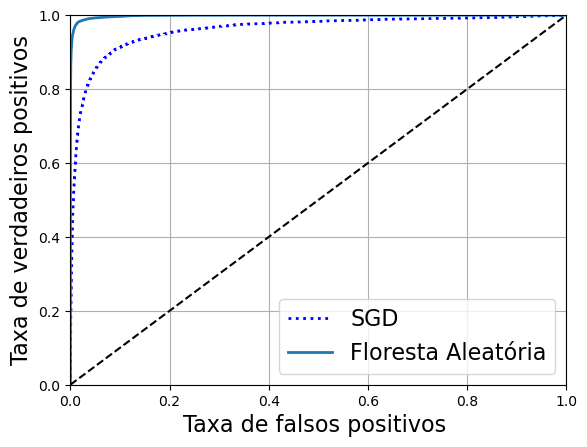

In [ ]:
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_curva_roc(fpr_floresta, tpr_floresta, "Floresta Aleatória")
plt.legend(loc="lower right", fontsize=16)
plt.show()

A curva ROC da floresta aleatória está bem mais distante da linha pontilhada do que a curva ROC do SGD. De fato, seu score é bem maior

In [ ]:
roc_auc_score(Y_treino_5, Y_scores_floresta)

0.9983436731328145

## Classificação Multiclasse (todos os algarismos)

Enquanto classificadores binários distinguem entre duas classes, classificadores multiclasse distinguem entre em mais de uma classe

Alguns algoritmos (como SGD, RandomForest e Naive Bayes) sabem lidar com múltiplas classes nativamente. Outros algoritmos (como SVMs e LogisticRegression) são classificadores estritamente binários, e para utilizá-los para identificar múltiplas classes, pode-se tomar duas estratégias: ***one-versus-the-rest (OvR)*** ou ***one-versus-one(OvO)***

***OvR (one-versus-the-rest)***: Aqui cria-se 10 classificadoes binários, um para cada dígito (ou seja, um detector de 1s, um detector de 2s, assim por diante...). Depois, para classificar uma imagem nova, compara-se o score de decisão para cada classificador binário e escolhe o maior.

***OvO (one-versus-one)***: Aqui, treina-se um classificador binário para cada par de dígitos, logo, se existem n classes, vão existir n x (n-1) / 2 classificadores binários. Para classificar uma nova imagem, observa-se qual classe ganha mais "duelos", obtendo o maior score.

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_treino, Y_treino)
svm.predict([algum_digito])

array([5], dtype=uint8)

O scikit-learn detecta automaticamente quando você tenta um algoritmo de classificação binário para uma tarefa de classificação multiclasse, e automaticamente roda ***OvR*** ou ***Ovo***

Aqui, por baixo dos panos o scikit-learn usou a estratégia ***OvO***

In [ ]:
algum_digito_scores = svm.decision_function([algum_digito])
algum_digito_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

De fato, a maior pontuação para a imagem contendo o algarismo 5

In [ ]:
np.argmax(algum_digito_scores)

5

Para forçar o scikit-learn usar uma estratégia específica (nesse caso a estratégia OvR):

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr = OneVsRestClassifier(SVC())
ovr.fit(X_treino, Y_treino)
ovr.predict([algum_digito])

array([5], dtype=uint8)

In [ ]:
len(ovr.estimators_)

10

In [ ]:
sgd.fit(X_treino, Y_treino)
sgd.predict([algum_digito])

array([3], dtype=uint8)

Observando o score que o SGDClassifier atribuiu para cada classe:

In [ ]:
sgd.decision_function([algum_digito])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

O classificador está bastante confiante com a sua previsão, para todas as outras classes que não são 5, o classificador atribuiu scores negativos

Pra avaliar esse modelo, usar validação cruzada

In [ ]:
cross_val_score(sgd, X_treino, Y_treino, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Ele teve uma precisão de acima de 85% para os três folds

Utilizando a técnica de padronização StandardScaler aos dados, a acurácia do modelo apresenta uma boa melhora

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_treino_escalado = scaler.fit_transform(X_treino.astype(np.float64))

In [ ]:
cross_val_score(sgd, X_treino_escalado, Y_treino, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Acima de 89% para todos os folds

## Análise de Erro

Para analisar os tipos de erro que o modelo comete, vou analisar a matriz de confusão

In [ ]:
Y_treino_pred = cross_val_predict(sgd, X_treino_escalado, Y_treino, cv=3)
confusao = confusion_matrix(Y_treino, Y_treino_pred)
confusao

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Para utilizar uma representação visual da matriz de confusão...

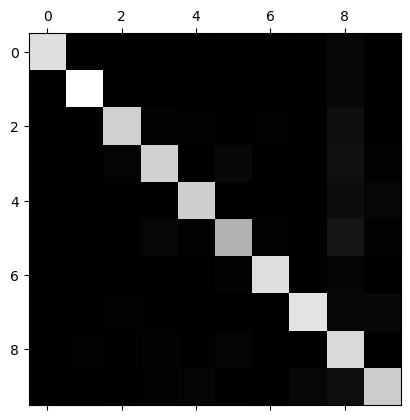

In [ ]:
plt.matshow(confusao, cmap=plt.cm.gray)
plt.show()

A matriz de confusão parece boa, com as maioria das imagens classificadas corretamente (diagonal principal bem clara). No entanto a classe 5 tem uma cor um pouco mais escura do que as outras, o que pode sinalizar que o dataset pode ter menos imagens da classe 5 do que as outras classes ou que o modelo não performa bem no dígito 5

Agora, vou tentar plotar os erros, para analisar que tipo de erros o classificador comete

In [ ]:
soma_linha = confusao.sum(axis=1, keepdims=True)
confusao_normalizada = confusao / soma_linha

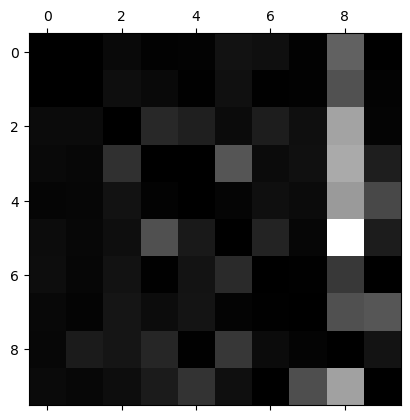

In [ ]:
np.fill_diagonal(confusao_normalizada, 0)
plt.matshow(confusao_normalizada, cmap=plt.cm.gray)
plt.show()

A classe 8 tem uma coluna de cor mais clara, indicando que muitas classes são classificadas errôneamente como 8. No entanto, a linha para a classe 8 não é tão ruim, indicando que algarismos que realmente são 8s, são classificados corretamente

Essa análise mostra que que os esforços para melhorar o modelo devem ser voltados para reduzir os falsos 8s. Soluções para isso seriam coletar mais dados de dígitos que parecem 8 mas não são, ou escrever um algoritmo que conta o número de loops fechados, no caso, o 8 tem dois loops fechados

In [ ]:
# Obs. essa é uma função auxiliar que eu peguei para exibir cada dígito
def plot_digitos(instances, images_per_row=10, **options):
    size = 28
    instances = np.array(instances).reshape(-1, size * size)
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)

    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")


Analisar erros individuais pode ser uma boa forma para ter insights de o que o classificador está fazendo e porque ele está falhando

Vamos plotar exemplos de dígitos classificados como 5 ou 3

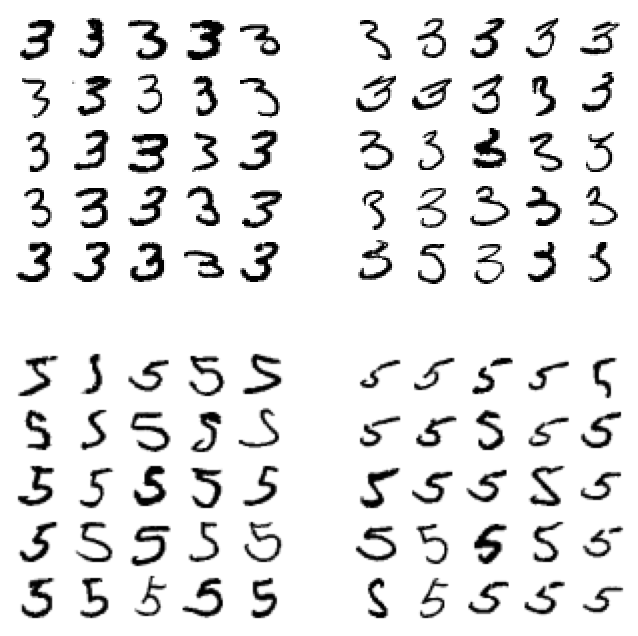

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_treino[(Y_treino == cl_a) & (Y_treino_pred == cl_a)]
X_ab = X_treino[(Y_treino == cl_a) & (Y_treino_pred == cl_b)]
X_ba = X_treino[(Y_treino == cl_b) & (Y_treino_pred == cl_a)]
X_bb = X_treino[(Y_treino == cl_b) & (Y_treino_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digitos(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digitos(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digitos(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digitos(X_bb[:25], images_per_row=5)
plt.show()

Os dois blocos à esquerda mostram os dígitos classificados como 3 e os dois blocos à direita mostram os dígitos classificados como 5. Alguns dígitos classificados errôneamente (no lado inferior esquerdo e no lado superior direito) são tão mal-escritos que até um ser humano teria problema para identificar

Mesmo assim, é estranho que o classificador tenha errado números que são identificados por nós ao observar a matriz. Isso se dá porque o SGDClassifier, que é um modelo linear, atribui um peso por classe para cada pixel, e quando vê uma nova imagem, soma todas as intensidades de pixel para conseguir um score para cada classe. Como 5 e 3 diferem por só alguns pixels, o modelo facilmente vai confundi-los

A diferença principal entre o 3 e o 5 é a posição da pequena linha que junta a linha horizontal em cima com o arco de baixo. Se focê desenha um três com essa ligação levemente voltada para esquerda, o classificador interpreta esse três como cinco. Isso significa que esse classificador é sensível à rotação de imagens. Para resolver isso, seria interessante pré-processar as imagens para que elas estivessem centradas

## Classificação Multirrótulo (extra)

Supondo que eu queira, em algum caso, gerar a saída de vários rótulos binários no meu sistema de classificação. Por exemplo, gerar a saída de dois rótulos, um deles diz se o algarismo classificado é grande (maior ou igual a 7) e se o algarismo classificado é ímpar. Para isso, eu utilizo uma classificação multirrótulo

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Y_treino_grande = (Y_treino >= 7)
Y_treino_impar = (Y_treino % 2 == 1)
Y_multirrotulo = np.c_[Y_treino_grande, Y_treino_impar]

knn = KNeighborsClassifier()
knn.fit(X_treino, Y_multirrotulo)

In [ ]:
knn.predict([algum_digito])

array([[False,  True]])

Acertou, o algarismo 5 é menor que 7 (False) e ímpar (True)

Uma das formas de avaliar um classificador multirrótulo é calculando o F1 score para cada rótulo individual e depois calcular o score médio

In [ ]:
Y_treino_knn_pred = cross_val_predict(knn, X_treino, Y_multirrotulo, cv=3)
f1_score(Y_multirrotulo, Y_treino_knn_pred, average="macro")

0.9764102655606048

Isso pressupõe que todos os rótulos são importantes. Caso se busque atribuir mais peso à um rótulo do que outro, basta atribuir a cada rótulo um peso igual ao seu support (definir average="weighted")

## Classificação Multioutput (extra)

Classificação Multioutput é um tipo de tarefa de classificação que é uma generalização da classificação multirrótulo, em que cada rótulo pode ter mais de um valor possível

Para exemplificar essa tarefa, vou criar um sistema que remove o ruído das imagens, gerando como saída multirrotulada, onde cada rótulo corresponde a um pixel e cada rótulo pode ter varios valores, já que a intensidade do pixel varia de 0 a 255

In [ ]:
# adicionando ruído às imagens do dataset com randint()
noise = np.random.randint(0, 100, (len(X_treino), 784))
X_train_mod = X_treino + noise
noise = np.random.randint(0, 100, (len(X_teste), 784))
X_test_mod = X_teste + noise
y_train_mod = X_treino
y_test_mod = X_teste

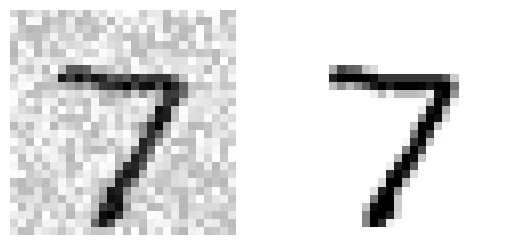

In [ ]:
plt.subplot(121); plot_digitos(X_test_mod.iloc[0].values)
plt.subplot(122); plot_digitos(y_test_mod.iloc[0].values)
plt.show()

À esquerda, a imagem com ruído e à direita a imagem alvo

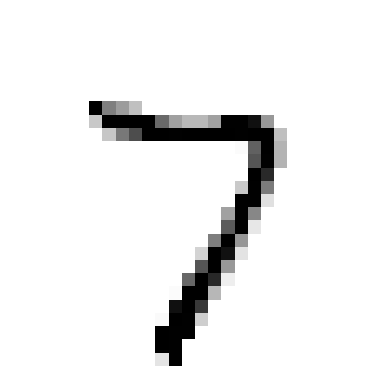

In [ ]:
knn.fit(X_train_mod, y_train_mod)
clean_digit = knn.predict([X_test_mod.iloc[0].values])
plot_digitos(clean_digit)

Após treinar o classificador e limpar a imagem, a saída parece bastante a imagem alvo